# Alternative Preprocessing Strategy for Classification

This notebook implements a robust preprocessing strategy for classification, with particular attention to preventing data leakage and ensuring reproducibility.

## Key Principles
- The train/test split is performed before any transformation.
- STKDE parameters are optimized only on the training data.
- All feature/label engineering is postponed to the modeling phase.
- Preprocessing pipelines are defined here but fitted only on the training data during modeling.

**Note:**
- All custom functions (e.g., cyclical_transform, BinarizeSinCosTransformer) are defined in `custom_transformers.py` to ensure modularity and reusability.
- The produced artifacts (data, pipeline, parameters, scoring_dict) are used by `Modeling.ipynb`.

# Setup

Import libraries, define paths, and prepare for preprocessing. All custom functions are imported from `custom_transformers.py` where needed.

## Google Drive Mount (optional)

If working locally, this cell can be ignored.

In [ ]:
# from google.colab import drive
# drive.mount('/drive', force_remount=True)

### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
from typing import List, Dict, Any, Tuple, Union
import time
from sklearn.model_selection import train_test_split
from sklearn.neighbors import BallTree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, StandardScaler, KBinsDiscretizer, Binarizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import random
from joblib import Parallel, delayed

from Utilities.custom_transformers import cyclical_transform

random.seed(42)
np.random.seed(42)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
print("Libraries imported and random seeds set.")


Libraries imported, logger configured, and random seeds set.


## Path Definition

Define paths for loading data and saving preprocessing artifacts.

In [ ]:
import os

base_dir = r"C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs"
feature_engineered_file_path = os.path.join(base_dir, "Final", "final_crime_data.csv")
save_dir = os.path.join(base_dir, "Classification (Preprocessing)")
os.makedirs(save_dir, exist_ok=True)

print(f"Notebook directory: {base_dir}")
print(f"Feature engineered file path: {feature_engineered_file_path}")
print(f"Save directory: {save_dir}")

Notebook directory: c:\Users\ferdi\Desktop\Uni\Roba\DMML
Feature engineered file path: c:\Users\ferdi\Desktop\Uni\Roba\DMML\Final\final_crime_data.csv
Save directory: c:\Users\ferdi\Desktop\Uni\Roba\DMML\Classification (Preprocessing)


### Load and validate feature engineered data

Load the dataset produced by the initial feature engineering phase.

In [ ]:
import pandas as pd

def load_basic_data_info(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    print(f"Loaded data: {df.shape[0]} rows, {df.shape[1]} columns")
    print("Columns:", df.columns.tolist())
    print(df.info())
    return df

df = load_basic_data_info(feature_engineered_file_path)

Loading data from: c:\Users\ferdi\Desktop\Uni\Roba\DMML\Final\final_crime_data.csv
Successfully loaded 2493835 rows and 48 columns
Columns in dataset: ['BORO_NM', 'KY_CD', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PD_CD', 'PREM_TYP_DESC', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'Latitude', 'Longitude', 'BAR_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE', 'ATMS_COUNT', 'BARS_COUNT', 'BUS_STOPS_COUNT', 'METROS_COUNT', 'NIGHTCLUBS_COUNT', 'SCHOOLS_COUNT', 'METRO_DISTANCE', 'MIN_POI_DISTANCE', 'AVG_POI_DISTANCE', 'MAX_POI_DISTANCE', 'BAR_DISTANCE_WITHIN_100M', 'NIGHTCLUB_DISTANCE_WITHIN_100M', 'ATM_DISTANCE_WITHIN_100M', 'METRO_DISTANCE_WITHIN_100M', 'TOTAL_POI_COUNT', 'POI_DIVERSITY', 'POI_DENSITY_SCORE', 'HOUR', 'DAY', 'WEEKDAY', 'IS_WEEKEND', 'MONTH', 'YEAR', 'SEASON', 'TIME_BUCKET', 'IS_HOLIDAY', 'IS_PAYDAY', 'SAME_AGE_GROUP', 'SAME_SEX', 'TO_CHECK_CITIZENS']
Starting data quality exploration

=== DATASET OVERVIEW ===
Shape: (2493835, 

## Data cleaning

- Remove irrelevant rows (`TO_CHECK_CITIZENS` = 0)
- Remove rows with unknown location
- Remove columns not available at prediction time

These steps ensure consistency with operational conditions and reliability of performance metrics.

In [ ]:
print("=== Data Cleaning ===")
initial_rows = len(df)
df_cleaned = df.copy()

# Remove rows not relevant to citizens
if 'TO_CHECK_CITIZENS' in df_cleaned.columns:
    citizen_mask = df_cleaned['TO_CHECK_CITIZENS'] != 0
    rows_removed = (~citizen_mask).sum()
    df_cleaned = df_cleaned[citizen_mask]
    print(f"Removed {rows_removed} rows where TO_CHECK_CITIZENS = 0") 

# Remove rows where the location is unknown
if 'LOC_OF_OCCUR_DESC' in df_cleaned.columns:
    if df_cleaned['LOC_OF_OCCUR_DESC'].dtype == 'object':
        location_mask = df_cleaned['LOC_OF_OCCUR_DESC'].str.upper() != 'UNKNOWN'
        rows_removed = (~location_mask).sum()
        df_cleaned = df_cleaned[location_mask]
        print(f"Removed {rows_removed} rows with UNKNOWN LOC_OF_OCCUR_DESC. Rows remaining: {len(df_cleaned)}") 
    else:
        print("'LOC_OF_OCCUR_DESC' is not of object type, skipping UNKNOWN location filter. It might be OHE.")
else:
    print("'LOC_OF_OCCUR_DESC' column not found, skipping UNKNOWN location filter.")

cols_to_drop = [
    'TO_CHECK_CITIZENS', 'KY_CD', 'LAW_CAT_CD', 
    'OFNS_DESC', 'PD_CD', 'PREM_TYP_DESC',
    'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX',
    'SAME_AGE_GROUP', 'SAME_SEX'
]

actual_cols_to_drop = [col for col in cols_to_drop if col in df_cleaned.columns]
if actual_cols_to_drop:
    df_cleaned = df_cleaned.drop(columns=actual_cols_to_drop)
    print(f"Dropped specified columns: {actual_cols_to_drop}. Columns remaining: {df_cleaned.shape[1]}") 
else:
    print("No specified columns from 'cols_to_drop' found to remove.") 

final_rows = len(df_cleaned)
print(f"Data cleaning completed: {initial_rows} -> {final_rows} rows ({ (f'{final_rows/initial_rows*100:.1f}% retained' if initial_rows > 0 else f'{0.0:.1f}%') })") 

# Clean the data
df = df_cleaned
print(f"Cleaned df shape: {df.shape}") 
if not df.empty:
    print(f"Cleaned df columns: {df.columns.tolist()}") 
else:
    print("Cleaned df is empty after cleaning steps.")

=== Data Cleaning ===
Removed 225707 rows where TO_CHECK_CITIZENS = 0
Removed 59725 rows with UNKNOWN LOC_OF_OCCUR_DESC. Rows remaining: 2208403
Dropped specified columns: ['TO_CHECK_CITIZENS', 'KY_CD', 'LAW_CAT_CD', 'OFNS_DESC', 'PD_CD', 'PREM_TYP_DESC', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'SAME_AGE_GROUP', 'SAME_SEX']. Columns remaining: 37
Data cleaning completed: 2493835 -> 2208403 rows (88.6% retained)
Cleaned df shape: (2208403, 37)
Cleaned df columns: ['BORO_NM', 'LOC_OF_OCCUR_DESC', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'Latitude', 'Longitude', 'BAR_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE', 'ATMS_COUNT', 'BARS_COUNT', 'BUS_STOPS_COUNT', 'METROS_COUNT', 'NIGHTCLUBS_COUNT', 'SCHOOLS_COUNT', 'METRO_DISTANCE', 'MIN_POI_DISTANCE', 'AVG_POI_DISTANCE', 'MAX_POI_DISTANCE', 'BAR_DISTANCE_WITHIN_100M', 'NIGHTCLUB_DISTANCE_WITHIN_100M', 'ATM_DISTANCE_WITHIN_100M', 'METRO_DISTANCE_WITHIN_100M', 'TOTAL_POI_COUNT', 'POI_DIVERSITY', 'POI_DENSITY_SCORE', 'HOUR', 'DAY', 'WEEKDAY

### Reduce the number of rows

In [ ]:
print("=== Applying Temporal Filter (YEAR >= 2023) ===") 
if 'YEAR' in df.columns:
    initial_rows_temporal_filter = len(df)
    df = df[df['YEAR'] >= 2023].copy()
    rows_after_temporal_filter = len(df)
    print(f"Filtered data to include only rows from 2023 onwards. Rows before: {initial_rows_temporal_filter}, Rows after: {rows_after_temporal_filter}") 
    if df.empty:
        print("DataFrame is empty after temporal filter.")
else:
    print("'YEAR' column not found. Skipping temporal filter.") 

=== Applying Temporal Filter (YEAR >= 2023) ===
Filtered data to include only rows from 2023 onwards. Rows before: 2208403, Rows after: 952392


## STKDE: parameter optimization only

The `stkde_intensity` column and the `RISK_LEVEL` label are **not** computed here to avoid leakage. Only parameter optimization is performed on X_train. Actual feature/label engineering will take place in `Modeling.ipynb`.

**Note:**
- `stkde_intensity` and `RISK_LEVEL` are not computed here to prevent data leakage.
- Only parameter optimization is performed here; feature and label engineering are postponed to the modeling phase.

In [ ]:
def calculate_stkde_intensity(df, year_col, month_col, day_col, hour_col, lat_col, lon_col, hs=200.0, ht=60.0):
    """
    Calculate STKDE intensity for each event in the DataFrame.
    """
    print(f"=== Calculating STKDE Intensity (Optimized Helper + NumPy Datetimes) ===")
    start_time = time.time()

    # Construct a temporary datetime column
    print(f"Constructing datetime from columns: {year_col}, {month_col}, {day_col}, {hour_col}")
    rename_dict = {year_col: 'year', month_col: 'month', day_col: 'day', hour_col: 'hour'}
    temp_datetime_col = '__temp_stkde_datetime__'
    df_copy = df.copy() # Work on a copy to avoid SettingWithCopyWarning
    
    # Validate input parameters
    if hs <= 0 or ht <= 0:
        print("Spatial and temporal bandwidths must be positive non-zero values.")
        df_copy['stkde_intensity'] = np.nan
        return df_copy
    
    # Validate input dataframe
    if df.empty:
        print("Input DataFrame is empty. Returning with NaN intensities.")
        df_copy['stkde_intensity'] = np.nan
        return df_copy
    
    # Check for required columns
    required_cols = [year_col, month_col, day_col, hour_col, lat_col, lon_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Missing required columns: {missing_cols}. Returning with NaN intensities.")
        df_copy['stkde_intensity'] = np.nan
        return df_copy
    
    try:
        for col in [year_col, month_col, day_col, hour_col]:
            df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')
        df_copy[temp_datetime_col] = pd.to_datetime(df_copy[[year_col, month_col, day_col, hour_col]].rename(columns=rename_dict))

        df_copy.dropna(subset=[temp_datetime_col, lat_col, lon_col], inplace=True)
        df_copy = df_copy.reset_index(drop=True)
    except Exception as e:
        print(f"Error constructing datetime column: {e}")
        df_copy['stkde_intensity'] = np.nan
        return df_copy # Return the copy with NaN intensity
    
    n_events = len(df_copy)
    if n_events == 0:
        print("No valid events found after datetime construction. Returning with NaN intensities.")
        df_copy['stkde_intensity'] = np.nan
        if temp_datetime_col in df_copy.columns:
            df_copy.drop(columns=[temp_datetime_col], inplace=True)
        return df_copy
    
    # Validate coordinate ranges
    lat_values = df_copy[lat_col].values
    lon_values = df_copy[lon_col].values
    
    if np.any((lat_values < -90) | (lat_values > 90)):
        print(f"Found latitude values outside valid range [-90, 90]. Min: {lat_values.min()}, Max: {lat_values.max()}")
    
    if np.any((lon_values < -180) | (lon_values > 180)):
        print(f"Found longitude values outside valid range [-180, 180]. Min: {lon_values.min()}, Max: {lon_values.max()}")
    
    try:
        coords = np.deg2rad(df_copy[[lat_col, lon_col]].values)
        tree = BallTree(coords, metric='haversine')
        earth_radius_m = 6371000.0
        datetime_values_np = df_copy[temp_datetime_col].values
    except Exception as e:
        print(f"Error during BallTree construction or coordinate conversion: {e}")
        df_copy['stkde_intensity'] = np.nan
        if temp_datetime_col in df_copy.columns:
            df_copy.drop(columns=[temp_datetime_col], inplace=True)
        return df_copy

    def k_s_kernel(d, hs_val):
        if hs_val <= 0: # Changed from hs_val == 0 to hs_val <= 0 for robustness
            return 0.0 # Return float
        return np.exp(-0.5 * (d / hs_val) ** 2) / (2 * np.pi * hs_val ** 2)

    def k_t_kernel(dt, ht_val):
        if ht_val <= 0: # Changed from ht_val == 0 to ht_val <= 0 for robustness
            return 0.0 # Return float
        return np.exp(-np.abs(dt) / ht_val) / ht_val

    spatial_query_radius_rad = (3 * hs) / earth_radius_m
    temporal_filter_cutoff_days = 3 * ht

    def _optimized_process_single_event(event_idx, all_datetime_values_np_ref, coords_rad_all_events_ref, ball_tree_ref, hs_val, ht_val, earth_radius_m_ref, spatial_query_radius_rad_ref, temporal_filter_cutoff_days_ref, k_s_func_ref, k_t_func_ref):
        try:
            target_coord_rad = coords_rad_all_events_ref[event_idx:event_idx + 1]
            target_datetime = all_datetime_values_np_ref[event_idx]
            neighbor_indices_arrays, neighbor_distances_rad_arrays = ball_tree_ref.query_radius(target_coord_rad, r=spatial_query_radius_rad_ref, return_distance=True)
            spatial_neighbor_indices = neighbor_indices_arrays[0]
            spatial_neighbor_distances_rad = neighbor_distances_rad_arrays[0]
            current_stkde_sum = 0.0
            if len(spatial_neighbor_indices) == 0:
                return 0.0
            for i_loop, neighbor_original_idx in enumerate(spatial_neighbor_indices):
                neighbor_datetime = all_datetime_values_np_ref[neighbor_original_idx]
                time_delta = target_datetime - neighbor_datetime
                time_delta_in_seconds = time_delta / np.timedelta64(1, 's')
                time_delta_days = time_delta_in_seconds / (24.0 * 3600.0)

                if abs(time_delta_days) > temporal_filter_cutoff_days_ref:
                    continue

                dist_meters = spatial_neighbor_distances_rad[i_loop] * earth_radius_m_ref
                weight_spatial = k_s_func_ref(dist_meters, hs_val)
                weight_temporal = k_t_func_ref(time_delta_days, ht_val)

                current_stkde_sum += weight_spatial * weight_temporal

            return current_stkde_sum
        except Exception as e:
            print(f"Error processing event {event_idx}: {e}")
            return 0.0

    print(f"Processing {n_events} events in parallel using joblib (n_jobs=-1) with optimized helper and NumPy datetimes...")

    try:
        stkde_intensities_list = Parallel(n_jobs=-1, verbose=10)(
            delayed(_optimized_process_single_event)(
                i, datetime_values_np, coords, tree, hs, ht, earth_radius_m, spatial_query_radius_rad, temporal_filter_cutoff_days, k_s_kernel, k_t_kernel
            ) for i in range(n_events)
        )
        stkde_intensities = np.array(stkde_intensities_list)
    except Exception as e:
        print(f"Error during parallel STKDE intensity calculation: {e}")
        df_copy['stkde_intensity'] = np.nan
        if temp_datetime_col in df_copy.columns:
            df_copy.drop(columns=[temp_datetime_col], inplace=True)
        return df_copy

    # Validate results
    if len(stkde_intensities) != n_events:
        print(f"Error: STKDE intensities length {len(stkde_intensities)} does not match number of events {n_events}. Returning NaN intensities.")
        df_copy['stkde_intensity'] = np.nan
    else:
        df_copy['stkde_intensity'] = stkde_intensities
        
        # Check for anomalous values
        nan_count = np.isnan(stkde_intensities).sum()
        inf_count = np.isinf(stkde_intensities).sum()
        zero_count = (stkde_intensities == 0).sum()
        
        if nan_count > 0:
           print(f"Found {nan_count} NaN values in STKDE intensities")
        if inf_count > 0:
           print(f"Found {inf_count} infinite values in STKDE intensities")
        if zero_count == n_events:
           print("All STKDE intensity values are zero - check bandwidth parameters")
        elif zero_count > n_events * 0.5:
           print(f"High proportion of zero STKDE intensities: {zero_count}/{n_events} ({zero_count/n_events*100:.1f}%)")

    if temp_datetime_col in df_copy.columns:
        df_copy.drop(columns=[temp_datetime_col], inplace=True)

    end_time = time.time()
    execution_time = end_time - start_time

    print(f"--- STKDE Calculation Report (Optimized Helper + NumPy Datetimes) ---")
    print(f"Total events processed: {n_events}")
    print(f"Spatial bandwidth (hs): {hs} m")
    print(f"Temporal bandwidth (ht): {ht} days")
    print(f"Execution time: {execution_time:.2f} seconds")
    if n_events > 0 and 'stkde_intensity' in df_copy.columns and not df_copy['stkde_intensity'].empty:
        valid_intensities = df_copy['stkde_intensity'].dropna()
        if len(valid_intensities) > 0:
            print(f"Min STKDE Intensity: {valid_intensities.min():.4e}")
            print(f"Max STKDE Intensity: {valid_intensities.max():.4e}")
            print(f"Mean STKDE Intensity: {valid_intensities.mean():.4e}")
            print(f"Median STKDE Intensity: {valid_intensities.median():.4e}")
        else:
           print("All STKDE intensity values are NaN")
    else:
       print("STKDE intensity statistics cannot be calculated (no events or intensity column missing/empty).")
    print(f"=================================\n")

    return df_copy 

## Data splitting

The creation of the 'RISK_LEVEL' column using qcut on the entire dataset has been disabled to prevent data leakage. This operation is performed only in the modeling pipeline, after the train/test split and within each cross-validation fold.

In [ ]:
print("=== Starting Data Splitting ===") 

# Initialize variables at the beginning of the cell
perform_temporal_split_successfully = False
unique_year_months = [] 
X_train, X_test = pd.DataFrame(), pd.DataFrame()
y_train, y_test = pd.Series(name='DUMMY_TARGET', dtype='object'), pd.Series(name='DUMMY_TARGET', dtype='object')

# Ensure YEAR and MONTH are numeric and sortable for temporal split
if not df.empty and 'YEAR' in df.columns and 'MONTH' in df.columns:
    df['YEAR'] = pd.to_numeric(df['YEAR'], errors='coerce')
    df['MONTH'] = pd.to_numeric(df['MONTH'], errors='coerce')
    df.dropna(subset=['YEAR', 'MONTH'], inplace=True)
    print(f"Ensured YEAR and MONTH are numeric. Rows after NaN drop (if any): {len(df)}") 
    
    if df.empty: # Check if df became empty after dropna
           print("DataFrame became empty after YEAR/MONTH processing. Cannot perform split.")
    else:
        df['YearMonth'] = df['YEAR'] * 100 + df['MONTH']
        df.sort_values('YearMonth', inplace=True)
        print("Created 'YearMonth' for sorting and df sorted.") 
        print(f"Distribution of data across YearMonth:\n{df['YearMonth'].value_counts().sort_index()}") 
        unique_year_months = df['YearMonth'].unique()
else:
   print("DataFrame is empty or YEAR/MONTH columns missing. Cannot perform temporal split based on YearMonth.")
    if df.empty:
        print("DataFrame is empty. Cannot perform split.")

# Attempt temporal split
if not df.empty and len(unique_year_months) >= 2: # Check df.empty again as it might have become empty
    total_rows = len(df)
    target_test_rows = total_rows * 0.18
    print(f"Attempting temporal split. Total rows: {total_rows}, target test rows (~20%): {target_test_rows:.0f}") 

    accumulated_rows_for_test = 0
    num_months_for_test_set = 0
    # This will be the OLDEST YearMonth included in the test set
    determined_test_set_start_ym = None

    # Iterate unique_year_months from newest to oldest
    for i in range(len(unique_year_months) - 1, -1, -1):
        ym = unique_year_months[i]
        rows_this_month = df[df['YearMonth'] == ym].shape[0]

        accumulated_rows_for_test += rows_this_month
        num_months_for_test_set += 1
        determined_test_set_start_ym = ym # This ym is the oldest month in the current selection

        if accumulated_rows_for_test >= target_test_rows:
            # Found the minimum number of recent months to meet the target
            break

    print(f"Temporal split scan: Test set would start from YearMonth {determined_test_set_start_ym}, include {num_months_for_test_set} month(s), accumulating {accumulated_rows_for_test} rows.") 

    if determined_test_set_start_ym is not None:
        if determined_test_set_start_ym > unique_year_months[0]: # Ensures training set is not empty
            X_train = df[df['YearMonth'] < determined_test_set_start_ym].copy()
            X_test = df[df['YearMonth'] >= determined_test_set_start_ym].copy()
            # Define y_train and y_test for successful temporal split
            y_train = pd.Series([0] * len(X_train), name='DUMMY_TARGET', dtype='object')
            y_test = pd.Series([0] * len(X_test), name='DUMMY_TARGET', dtype='object')

            print(f"Temporal split successful: Test set starts from YearMonth {determined_test_set_start_ym}.") 
            print(f"  Test set rows: {len(X_test)} (~{len(X_test)/total_rows*100:.2f}% of data).") 
            print(f"  Train set rows: {len(X_train)}.") 
            perform_temporal_split_successfully = True
        else:
           print("Temporal split would result in an empty training set. Falling back to random split.")
            # perform_temporal_split_successfully remains False
    else:
       print("Could not determine a temporal cutoff for splitting. Falling back to random split.")
        # perform_temporal_split_successfully remains False

elif not df.empty: # If df not empty but unique_year_months < 2
   print(f"Not enough unique YearMonth values ({len(unique_year_months)}) for temporal split. Falling back to random split.")
    # perform_temporal_split_successfully remains False

# Fallback to random split if temporal split was not successful and df is not empty
if not perform_temporal_split_successfully and not df.empty:
    print("Performing random split (20% test size, random_state=42).") 
    random_state = 42
    # Stratify=None because y is a dummy target.
    # Ensure df passed to train_test_split does not have 'YearMonth' if it was added
    df_for_split = df.copy()
    if 'YearMonth' in df_for_split.columns:
        df_for_split.drop(columns=['YearMonth'], inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(
        df_for_split, pd.Series([0] * len(df_for_split), name='DUMMY_TARGET', dtype='object'), 
        test_size=0.2, random_state=random_state, stratify=None
    )
    print("Random split performed.") 
elif df.empty and not perform_temporal_split_successfully: # df is empty
    print("DataFrame is empty. Split resulted in empty sets.")

# Drop 'YearMonth' from X_train, X_test, and original X (if it was added to X directly)
if 'YearMonth' in X_train.columns: X_train.drop(columns=['YearMonth'], inplace=True)
if 'YearMonth' in X_test.columns: X_test.drop(columns=['YearMonth'], inplace=True)
if 'YearMonth' in df.columns: df.drop(columns=['YearMonth'], inplace=True) # Clean from original df too

print(f"Training set size (X_train): {X_train.shape[0]} rows, {X_train.shape[1]} columns") 
print(f"Test set size (X_test): {X_test.shape[0]} rows, {X_test.shape[1]} columns") 
print(f"y_train size: {y_train.shape[0]}, y_test size: {y_test.shape[0]}") 

if not X_train.empty:
    print(f"X_train columns: {X_train.columns.tolist()}") 
print("X_train will now be used for STKDE parameter LCV and scaler selection.") 

=== Starting Data Splitting ===
Ensured YEAR and MONTH are numeric. Rows after NaN drop (if any): 952392
Created 'YearMonth' for sorting and df sorted.
Distribution of data across YearMonth:
YearMonth
202301    39126
202302    34440
202303    38856
202304    38363
202305    42004
202306    41541
202307    42563
202308    42050
202309    39404
202310    41374
202311    38549
202312    38959
202401    38565
202402    36477
202403    38960
202404    38331
202405    42048
202406    41867
202407    42744
202408    41959
202409    40718
202410    41663
202411    38132
202412    33699
Name: count, dtype: int64
Attempting temporal split. Total rows: 952392, target test rows (~20%): 171431
Temporal split scan: Test set would start from YearMonth 202408, include 5 month(s), accumulating 196171 rows.
Temporal split successful: Test set starts from YearMonth 202408.
  Test set rows: 196171 (~20.60% of data).
  Train set rows: 756221.
Training set size (X_train): 756221 rows, 37 columns
Test set si

In [ ]:
# Initialize STKDE parameters and related variables at the beginning of the cell
hs_opt = None
ht_opt = None
required_cols_for_stkde = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'Latitude', 'Longitude']
params_file_path = os.path.join(save_dir, "stkde_optimal_params.json")
lcv_needed = True

print(f"Checking for existing STKDE optimal parameters at: {params_file_path}") 
if os.path.exists(params_file_path):
    try:
        with open(params_file_path, 'r') as f:
            params = json.load(f)
            hs_opt = params.get('hs_opt')
            ht_opt = params.get('ht_opt')
            if hs_opt is not None and ht_opt is not None and isinstance(hs_opt, (int, float)) and isinstance(ht_opt, (int, float)):
                print(f"Loaded optimal STKDE parameters from {params_file_path}: hs_opt={hs_opt}, ht_opt={ht_opt}") 
                lcv_needed = False
            else:
                print(f"Parameter file {params_file_path} found but parameters are invalid or not numeric. LCV will run.")
                lcv_needed = True # Ensure LCV runs if params are not valid
    except Exception as e:
        print(f"Error loading parameters from {params_file_path}: {e}. LCV will run.")
        lcv_needed = True # Ensure LCV runs on error
else:
    print(f"STKDE parameter file not found at {params_file_path}. LCV will run.") 


if lcv_needed:
    print("=== Likelihood Cross-Validation for STKDE Parameter Optimization (Running LCV in Parallel on X_train) ===") 
    if X_train.empty or not all(col in X_train.columns for col in required_cols_for_stkde):
        print(f"X_train is empty or one or more required columns for STKDE LCV are missing in X_train: {required_cols_for_stkde}. Available: {X_train.columns.tolist() if not X_train.empty else 'X_train is empty'}")
        print(f"LCV cannot run. Will use default parameters if not loaded.")
    else:
        print(f"Performing LCV on X_train (shape: {X_train.shape}) to find optimal STKDE parameters.") 
        df_lcv = X_train.copy() # Operate on a copy of X_train
        
        # Datetime conversion for LCV data (similar to calculate_stkde_intensity)
        temp_datetime_col_lcv = '__temp_lcv_datetime__'
        rename_dict_lcv = {'YEAR': 'year', 'MONTH': 'month', 'DAY': 'day', 'HOUR': 'hour'}
        try:
            for col in ['YEAR', 'MONTH', 'DAY', 'HOUR']:
                df_lcv[col] = pd.to_numeric(df_lcv[col], errors='coerce')
            df_lcv[temp_datetime_col_lcv] = pd.to_datetime(
                df_lcv[['YEAR', 'MONTH', 'DAY', 'HOUR']].rename(columns=rename_dict_lcv)
            )
            df_lcv.dropna(subset=[temp_datetime_col_lcv, 'Latitude', 'Longitude'], inplace=True)
            if temp_datetime_col_lcv in df_lcv.columns: 
                df_lcv.drop(columns=[temp_datetime_col_lcv], inplace=True)
            df_lcv = df_lcv.reset_index(drop=True)
            print(f"LCV data prepared. Shape: {df_lcv.shape}") 
        except Exception as e:
            print(f"Error during LCV data preparation (on X_train copy): {e}")
            df_lcv = pd.DataFrame() 

        if df_lcv.empty:
           print("DataFrame for LCV (from X_train) is empty after cleaning. Skipping LCV calculation.")
        else:
            max_lcv_rows = 7500
            if len(df_lcv) > max_lcv_rows:
                print(f"Randomly sampling {max_lcv_rows} events from the training set for LCV (out of {len(df_lcv)} available).") 
                df_lcv_sampled = df_lcv.sample(n=max_lcv_rows, random_state=42)
            else:
                print(f"Using all {len(df_lcv)} events from the training set for LCV.") 
                df_lcv_sampled = df_lcv
            print(f"Starting LCV on {len(df_lcv_sampled)} events (from X_train sample).") 

            hs_values_coarse = list(range(50, 501, 50))
            ht_values_coarse = list(range(10, 121, 10))
            print(f"[Coarse] LCV grid: hs_values={hs_values_coarse}, ht_values={ht_values_coarse}") 
            
            def evaluate_lcv_candidate(params_eval, df_for_eval):
                hs_candidate, ht_candidate = params_eval
                df_with_intensity = calculate_stkde_intensity(df_for_eval.copy(),
                                                              year_col='YEAR', month_col='MONTH',
                                                              day_col='DAY', hour_col='HOUR',
                                                              lat_col='Latitude', lon_col='Longitude',
                                                              hs=hs_candidate, ht=ht_candidate)
                current_intensity_values = df_with_intensity['stkde_intensity']
                valid_intensities = current_intensity_values[current_intensity_values > 1e-9]
                if len(valid_intensities) == 0:
                    lcv_score_val = -np.inf
                else:
                    lcv_score_val = np.sum(np.log(valid_intensities))
                return lcv_score_val, hs_candidate, ht_candidate

            param_candidates_coarse = [(hs_cand, ht_cand) for hs_cand in hs_values_coarse for ht_cand in ht_values_coarse]
            print(f"Running {len(param_candidates_coarse)} LCV candidates in parallel (coarse grid)...") 
            results_coarse = Parallel(n_jobs=-1, verbose=0)(
                delayed(evaluate_lcv_candidate)(params_cand, df_lcv_sampled) for params_cand in param_candidates_coarse
            )
            best_lcv_score_coarse = -np.inf
            temp_hs_opt_coarse, temp_ht_opt_coarse = None, None
            for lcv_score_res, hs_res, ht_res in results_coarse:
                if lcv_score_res > best_lcv_score_coarse:
                    best_lcv_score_coarse = lcv_score_res
                    temp_hs_opt_coarse = hs_res
                    temp_ht_opt_coarse = ht_res
            print(f"[Coarse] Best LCV params: hs={temp_hs_opt_coarse}, ht={temp_ht_opt_coarse}, LCV Score={best_lcv_score_coarse}") 

            if temp_hs_opt_coarse is not None and temp_ht_opt_coarse is not None:
                # Fine-tuning phase
                hs_fine_min = max(50, temp_hs_opt_coarse - 40)
                hs_fine_max = temp_hs_opt_coarse + 40
                ht_fine_min = max(10, temp_ht_opt_coarse - 20)
                ht_fine_max = temp_ht_opt_coarse + 20
                hs_values_fine = list(range(int(hs_fine_min), int(hs_fine_max)+1, 10))
                ht_values_fine = list(range(int(ht_fine_min), int(ht_fine_max)+1, 5))
                print(f"[Fine] LCV grid: hs_values={hs_values_fine}, ht_values={ht_values_fine}") 
                
                param_candidates_fine = [(hs_cand, ht_cand) for hs_cand in hs_values_fine for ht_cand in ht_values_fine]
                print(f"Running {len(param_candidates_fine)} LCV candidates in parallel (fine grid)...") 
                results_fine = Parallel(n_jobs=-1, verbose=0)(
                    delayed(evaluate_lcv_candidate)(params_cand, df_lcv_sampled) for params_cand in param_candidates_fine
                )
                best_lcv_score_fine = -np.inf
                temp_hs_opt_fine, temp_ht_opt_fine = None, None
                for lcv_score_res, hs_res, ht_res in results_fine:
                    if lcv_score_res > best_lcv_score_fine:
                        best_lcv_score_fine = lcv_score_res
                        temp_hs_opt_fine = hs_res
                        temp_ht_opt_fine = ht_res
                print(f"[Fine] Best: hs={temp_hs_opt_fine}, ht={temp_ht_opt_fine}, LCV Score={best_lcv_score_fine}") 
                
                if temp_hs_opt_fine is not None and temp_ht_opt_fine is not None:
                    hs_opt = temp_hs_opt_fine
                    ht_opt = temp_ht_opt_fine
                    print(f"--- LCV Optimization Complete (Coarse to Fine) ---") 
                    print(f"Optimal parameters found via LCV: hs_opt = {hs_opt} m, ht_opt = {ht_opt} days") 
                    print(f"Best LCV Score: {best_lcv_score_fine}") 
                    try:
                        with open(params_file_path, 'w') as f:
                            json.dump({'hs_opt': hs_opt, 'ht_opt': ht_opt}, f)
                        print(f"Saved optimal STKDE parameters to {params_file_path}") 
                    except Exception as e:
                        print(f"Error saving STKDE parameters to {params_file_path}: {e}")
                else:
                    print("Fine grid did not find optimal parameters. Using coarse grid result.") 
                    hs_opt = temp_hs_opt_coarse
                    ht_opt = temp_ht_opt_coarse
                    print(f"--- LCV Optimization Complete (Using Coarse Grid Result) ---") 
                    print(f"Optimal parameters found via LCV: hs_opt = {hs_opt} m, ht_opt = {ht_opt} days") 
                    print(f"Best LCV Score: {best_lcv_score_coarse}") 
                    try:
                        with open(params_file_path, 'w') as f:
                            json.dump({'hs_opt': hs_opt, 'ht_opt': ht_opt}, f)
                        print(f"Saved optimal STKDE parameters to {params_file_path}") 
                    except Exception as e:
                        print(f"Error saving STKDE parameters to {params_file_path}: {e}")
            else:
               print("Coarse grid did not find optimal STKDE parameters. Parameters file not updated by LCV.")
else:
    print("Skipping STKDE LCV run as optimal parameters were loaded or LCV was previously determined not to be needed.") 

if hs_opt is None:
    print("hs_opt is None after LCV/loading attempts, falling back to default 200.0.")
    hs_opt = 200.0
if ht_opt is None:
    print("ht_opt is None after LCV/loading attempts, falling back to default 60.0.")
    ht_opt = 60.0

print(f"Using parameters for STKDE (derived from X_train LCV, loaded, or default): hs_opt = {hs_opt} m, ht_opt = {ht_opt} days") 

Checking for existing STKDE optimal parameters at: c:\Users\ferdi\Desktop\Uni\Roba\DMML\Classification (Preprocessing)\stkde_optimal_params.json
Loaded optimal STKDE parameters from c:\Users\ferdi\Desktop\Uni\Roba\DMML\Classification (Preprocessing)\stkde_optimal_params.json: hs_opt=50, ht_opt=10
Skipping STKDE LCV run as optimal parameters were loaded or LCV was previously determined not to be needed.
Using parameters for STKDE (derived from X_train LCV, loaded, or default): hs_opt = 50 m, ht_opt = 10 days


# Preprocessing Pipeline (Encoding, Scaling, Feature Selection, PCA)

Preprocessing steps are defined for different model types, using scikit-learn's `Pipeline` and `ColumnTransformer` to avoid data leakage. Pipelines are fit only on the training set in the modeling phase.

This includes:
- **Ordinal encoding** for ordinal categorical features (in general and tree pipelines).
- **One-hot encoding** for nominal categorical features.
- **Cyclical encoding** for cyclical features (custom transformer).
- **Scaling** (RobustScaler) for general pipeline.
- **Feature selection** (RandomForest importance) in general and tree pipelines.
- **Dimensionality reduction** (PCA) for general pipeline.

All column lists are dynamically checked against the columns present in `X_train`.

**Best Practice Check:**

- The general pipeline (with scaling and PCA) is used for linear models and distance-based models (e.g., LogisticRegression, KNN, SVC).
- The tree pipeline (OrdinalEncoder for all categoricals, no scaling/PCA) is used for tree-based models (DecisionTree, RandomForest, GradientBoosting).
- All pipelines are fit only on the training set, and then applied to the test set, avoiding data leakage.

This structure is correct and follows best practices for model-specific preprocessing.

In [ ]:
print("=== Defining Preprocessing Pipelines ===") 

# Define chosen_scaler_class before it is used
from sklearn.preprocessing import RobustScaler 
chosen_scaler_class = RobustScaler # Default scaler class, can be changed later

if 'X_train' in locals() and not X_train.empty:
    train_cols = X_train.columns.tolist()
    print(f"X_train columns available for pipeline definition: {train_cols[:15]}...") 
else:
    print("X_train is not defined or is empty. Cannot define pipelines. Please check data splitting step.")
    train_cols = [] 

ordinal_cols_potential = ['VIC_AGE_GROUP']
nominal_cols_potential = ['BORO_NM', 'LOC_OF_OCCUR_DESC', 'VIC_RACE', 'VIC_SEX', 'SEASON', 'TIME_BUCKET']
cyclical_cols_potential = ['HOUR', 'WEEKDAY', 'MONTH']
numeric_cols_potential = ['Latitude', 'Longitude', 'YEAR', 'BARS_COUNT', 'NIGHTCLUBS_COUNT', 'ATMS_COUNT', 
                          'METROS_COUNT', 'BUS_STOPS_COUNT', 'SCHOOLS_COUNT', 'BAR_DISTANCE', 'NIGHTCLUB_DISTANCE', 
                          'ATM_DISTANCE', 'METRO_DISTANCE', 'TOTAL_POI_COUNT', 'POI_DIVERSITY', 'MIN_POI_DISTANCE',
                          'AVG_POI_DISTANCE', 'MAX_POI_DISTANCE', 'POI_DENSITY_SCORE'] # STKDE intensity will be added later if generated

ordinal_cols = [col for col in ordinal_cols_potential if col in train_cols]
nominal_cols = [col for col in nominal_cols_potential if col in train_cols]
cyclical_cols = [col for col in cyclical_cols_potential if col in train_cols]
numeric_cols = [col for col in numeric_cols_potential if col in train_cols]

print(f"Ordinal columns selected: {ordinal_cols}")
print(f"Nominal columns selected: {nominal_cols}")
print(f"Cyclical columns selected: {cyclical_cols}")
print(f"Numeric columns selected: {numeric_cols}")

try:
    from Utilities.custom_transformers import cyclical_transform 
    from sklearn.preprocessing import FunctionTransformer 
except ImportError as e:
    print(f"Error importing custom transformers: {e}")
    raise

cyclical_transformer = FunctionTransformer(cyclical_transform, validate=False)

ordinal_categories = []
if 'VIC_AGE_GROUP' in ordinal_cols:
    ordinal_categories = [['<18', '18-24', '25-44', '45-64', '65+', 'UNKNOWN']]
else:
    ordinal_cols = [] 

from sklearn.base import clone 

random_state = 42

transformers_full = []
if ordinal_cols:
    transformers_full.append(('ord', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols))
if nominal_cols:
    transformers_full.append(('nom', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.uint8), nominal_cols))
if cyclical_cols:
    transformers_full.append(('cyc', cyclical_transformer, cyclical_cols))
if numeric_cols: 
    transformers_full.append(('num', chosen_scaler_class(), numeric_cols))

if not transformers_full:
    print("Warning: No transformers applicable based on X_train columns. Preprocessor will be empty.")
    preprocessor_full = ColumnTransformer([], remainder='passthrough')
else:
    preprocessor_full = ColumnTransformer(transformers_full, remainder='passthrough', n_jobs=-1)

preprocessing_pipeline_general = Pipeline([
    ('preprocessor', preprocessor_full),
    ('pca', PCA(n_components=0.95, random_state=random_state))
])
print(f"General preprocessing pipeline defined using {chosen_scaler_class.__name__} and PCA.") 

all_categorical_cols_for_trees = ordinal_cols + nominal_cols
transformers_trees = []

# Revised logic for tree ordinal encoder:
current_ordinal_categories_for_trees = []
cols_for_tree_ordinal_encoder_specific_cats = []
other_categoricals_for_trees_infer_cats = []

if 'VIC_AGE_GROUP' in all_categorical_cols_for_trees and 'VIC_AGE_GROUP' in ordinal_cols and ordinal_categories:
    current_ordinal_categories_for_trees.append(ordinal_categories[0]) 
    cols_for_tree_ordinal_encoder_specific_cats.append('VIC_AGE_GROUP')

other_categoricals_for_trees_infer_cats = [col for col in all_categorical_cols_for_trees if col not in cols_for_tree_ordinal_encoder_specific_cats]

if cols_for_tree_ordinal_encoder_specific_cats:
    transformers_trees.append((
        'ord_specific_cats',
        OrdinalEncoder(categories=current_ordinal_categories_for_trees, handle_unknown='use_encoded_value', unknown_value=-1),
        cols_for_tree_ordinal_encoder_specific_cats
    ))

if other_categoricals_for_trees_infer_cats:
    transformers_trees.append((
        'ord_infer_cats',
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        other_categoricals_for_trees_infer_cats
    ))

if cyclical_cols:
    transformers_trees.append(('cyc', cyclical_transformer, cyclical_cols))

if not transformers_trees:
    print("Warning: No transformers applicable for tree-based models. Preprocessor_trees will be empty.")
    preprocessor_trees = ColumnTransformer([], remainder='passthrough')
else:
    preprocessor_trees = ColumnTransformer(
        transformers=transformers_trees,
        remainder='passthrough',
        n_jobs=-1
    )
# preprocessor_trees.set_output(transform="pandas") # Uncomment if needed

=== Defining Preprocessing Pipelines ===
X_train columns available for pipeline definition: ['BORO_NM', 'LOC_OF_OCCUR_DESC', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'Latitude', 'Longitude', 'BAR_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE', 'ATMS_COUNT', 'BARS_COUNT', 'BUS_STOPS_COUNT', 'METROS_COUNT', 'NIGHTCLUBS_COUNT']...
Ordinal columns selected: ['VIC_AGE_GROUP']
Nominal columns selected: ['BORO_NM', 'LOC_OF_OCCUR_DESC', 'VIC_RACE', 'VIC_SEX', 'SEASON', 'TIME_BUCKET']
Cyclical columns selected: ['HOUR', 'WEEKDAY', 'MONTH']
Numeric columns selected: ['Latitude', 'Longitude', 'YEAR', 'BARS_COUNT', 'NIGHTCLUBS_COUNT', 'ATMS_COUNT', 'METROS_COUNT', 'BUS_STOPS_COUNT', 'SCHOOLS_COUNT', 'BAR_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE', 'METRO_DISTANCE', 'TOTAL_POI_COUNT', 'POI_DIVERSITY', 'MIN_POI_DISTANCE', 'AVG_POI_DISTANCE', 'MAX_POI_DISTANCE', 'POI_DENSITY_SCORE']
General preprocessing pipeline defined using RobustScaler and PCA.


## Saving artifacts

Save the unprocessed train/test sets, pipeline definitions, and scoring metrics for use in the modeling phase.

In [ ]:
print("\n=== Saving Unprocessed Train/Test Sets, Pipeline Definitions, and Other Artifacts ===") 

import joblib
import numpy as np # Ensure numpy is imported if not already in this cell scope
import os # Ensure os is imported

# Ensure save_dir exists (it should from earlier cell)
os.makedirs(save_dir, exist_ok=True)
print(f"Artifacts will be saved in: {save_dir}") 

# Save unprocessed data (X_train, X_test, y_train, y_test)
# y_train/y_test are currently dummy variables.
feature_names_to_save = []

if 'X_train' in locals() and not X_train.empty:
    try:
        np.save(os.path.join(save_dir, 'X_train.npy'), X_train.values)
        feature_names_to_save = X_train.columns.tolist()
        joblib.dump(feature_names_to_save, os.path.join(save_dir, 'X_feature_names.joblib'))
        print(f"X_train saved ({X_train.shape}). Feature names saved ({len(feature_names_to_save)} features).") 
    except Exception as e:
        print(f"Error saving X_train or feature names: {e}")
else:
    print("X_train is not available or empty. Not saving X_train or its feature names.")

if 'X_test' in locals() and not X_test.empty:
    try:
        # Only save X_test if its columns match X_train's feature names
        if feature_names_to_save and list(X_test.columns) == feature_names_to_save:
             np.save(os.path.join(save_dir, 'X_test.npy'), X_test.values)
             print(f"X_test saved ({X_test.shape}).") 
        elif not feature_names_to_save: # If X_train was empty, save X_test if it exists
            np.save(os.path.join(save_dir, 'X_test.npy'), X_test.values)
            joblib.dump(X_test.columns.tolist(), os.path.join(save_dir, 'X_feature_names.joblib')) # Save X_test features then
            print(f"X_test saved ({X_test.shape}). Feature names from X_test saved.") 
        else:
           print(f"X_test columns do not match X_train columns. X_test not saved as .npy to avoid inconsistency. X_test columns: {X_test.columns.tolist()}")
    except Exception as e:
        print(f"Error saving X_test: {e}")
else:
    print("X_test is not available or empty. Not saving X_test.")

if 'y_train' in locals() and not y_train.empty:
    try:
        np.save(os.path.join(save_dir, 'y_train.npy'), y_train.values)
        print(f"y_train saved ({y_train.shape}).") 
    except Exception as e:
        print(f"Error saving y_train: {e}")
else:
    print("y_train is not available or empty. Not saving y_train.")

if 'y_test' in locals() and not y_test.empty:
    try:
        np.save(os.path.join(save_dir, 'y_test.npy'), y_test.values)
        print(f"y_test saved ({y_test.shape}).") 
    except Exception as e:
        print(f"Error saving y_test: {e}")
else:
    print("y_test is not available or empty. Not saving y_test.")


if 'preprocessing_pipeline_general' in locals():
    pipeline_general_path = os.path.join(save_dir, 'preprocessing_pipeline_general.joblib')
    try:
        joblib.dump(preprocessing_pipeline_general, pipeline_general_path)
        print(f"Unfitted general preprocessing pipeline saved to: {pipeline_general_path}") 
    except Exception as e:
        print(f"Error saving general preprocessing pipeline: {e}")
else:
    print("General preprocessing pipeline is not defined. Not saving.")

if 'preprocessor_trees' in locals():
    pipeline_trees_path = os.path.join(save_dir, 'preprocessing_pipeline_trees.joblib')
    try:
        joblib.dump(preprocessor_trees, pipeline_trees_path)
        print(f"Unfitted tree-optimized preprocessing pipeline saved to: {pipeline_trees_path}") 
    except Exception as e:
        print(f"Error saving tree-optimized preprocessing pipeline: {e}")
else:
    print("Tree-optimized preprocessing pipeline is not defined. Not saving.")

# Save also the unfitted ColumnTransformers (not full pipelines) for use as steps in other pipelines
if 'preprocessor_full' in locals():
    try:
        joblib.dump(preprocessor_full, os.path.join(save_dir, 'preprocessor_full.joblib'))
        print("Unfitted general ColumnTransformer (preprocessor_full) saved.") 
    except Exception as e:
        print(f"Error saving preprocessor_full: {e}")
else:
    print("General ColumnTransformer is not defined. Not saving.")

if 'preprocessor_trees' in locals():
    try:
        joblib.dump(preprocessor_trees, os.path.join(save_dir, 'preprocessor_trees.joblib'))
        print("Unfitted tree-optimized ColumnTransformer (preprocessor_trees) saved.") 
    except Exception as e:
        print(f"Error saving preprocessor_trees: {e}")
else:
    print("Tree-optimized ColumnTransformer is not defined. Not saving.")

# Save the optimal STKDE parameters to a JSON file
stkde_params_path = os.path.join(save_dir, "stkde_optimal_params.json")
scaler_info_path = os.path.join(save_dir, "scaler_info.json")

try:
    with open(stkde_params_path, 'w') as f:
        json.dump({'hs_opt': hs_opt, 'ht_opt': ht_opt}, f)
    print(f"STKDE optimal parameters (hs_opt: {hs_opt}, ht_opt: {ht_opt}) saved to {stkde_params_path}") 
except Exception as e:
    print(f"Error saving STKDE optimal parameters: {e}")

try:
    with open(scaler_info_path, 'w') as f:
        json.dump({'chosen_scaler_class_name': chosen_scaler_class.__name__}, f)
    print(f"Chosen scaler class name ({chosen_scaler_class.__name__}) saved to {scaler_info_path}") 
except Exception as e:
    print(f"Error saving chosen_scaler_info: {e}")

print("Artifact saving process completed.") 


=== Saving Unprocessed Train/Test Sets, Pipeline Definitions, and Other Artifacts ===
Artifacts will be saved in: c:\Users\ferdi\Desktop\Uni\Roba\DMML\Classification (Preprocessing)
X_train saved ((756221, 37)). Feature names saved (37 features).
X_test saved ((196171, 37)).
y_train saved ((756221,)).
y_test saved ((196171,)).
Unfitted general preprocessing pipeline saved to: c:\Users\ferdi\Desktop\Uni\Roba\DMML\Classification (Preprocessing)\preprocessing_pipeline_general.joblib
Unfitted tree-optimized preprocessing pipeline saved to: c:\Users\ferdi\Desktop\Uni\Roba\DMML\Classification (Preprocessing)\preprocessing_pipeline_trees.joblib
Unfitted general ColumnTransformer (preprocessor_full) saved.
Unfitted tree-optimized ColumnTransformer (preprocessor_trees) saved.
STKDE optimal parameters (hs_opt: 50, ht_opt: 10) saved to c:\Users\ferdi\Desktop\Uni\Roba\DMML\Classification (Preprocessing)\stkde_optimal_params.json
Chosen scaler class name (RobustScaler) saved to c:\Users\ferdi\Desk

# Conclusions and Next Steps

- Data loaded, cleaned, and split into train/test sets.
- STKDE parameters optimized only on training data.
- Preprocessing pipelines defined for different model types.
- All feature and label engineering, as well as pipeline fitting, are postponed to the modeling phase to prevent data leakage.

Proceed with `Modeling.ipynb` for feature engineering, target creation, pipeline fitting, and model training.


=== Final Data Scan (Unprocessed Training Data) ===
X_train shape: (756221, 37)
Sample of X_train (first 5 rows):
           BORO_NM LOC_OF_OCCUR_DESC VIC_AGE_GROUP        VIC_RACE VIC_SEX  \
1090118   BROOKLYN            INSIDE       UNKNOWN         UNKNOWN       E   
2117940      BRONX             FRONT         45-64           WHITE       M   
190413    BROOKLYN            INSIDE         25-44  WHITE HISPANIC       M   
1490594   BROOKLYN            INSIDE       UNKNOWN         UNKNOWN       E   
489220   MANHATTAN            INSIDE       UNKNOWN  WHITE HISPANIC       F   

          Latitude  Longitude  BAR_DISTANCE  NIGHTCLUB_DISTANCE  ATM_DISTANCE  \
1090118  40.695783 -73.939093    402.949540          319.014935   1772.731299   
2117940  40.846525 -73.848479    602.535554         1599.647335    902.013957   
190413   40.651388 -74.005620    108.637625         3120.231839   1452.244392   
1490594  40.660526 -73.911814    918.616738         2423.761226   2858.177230   
489220   40

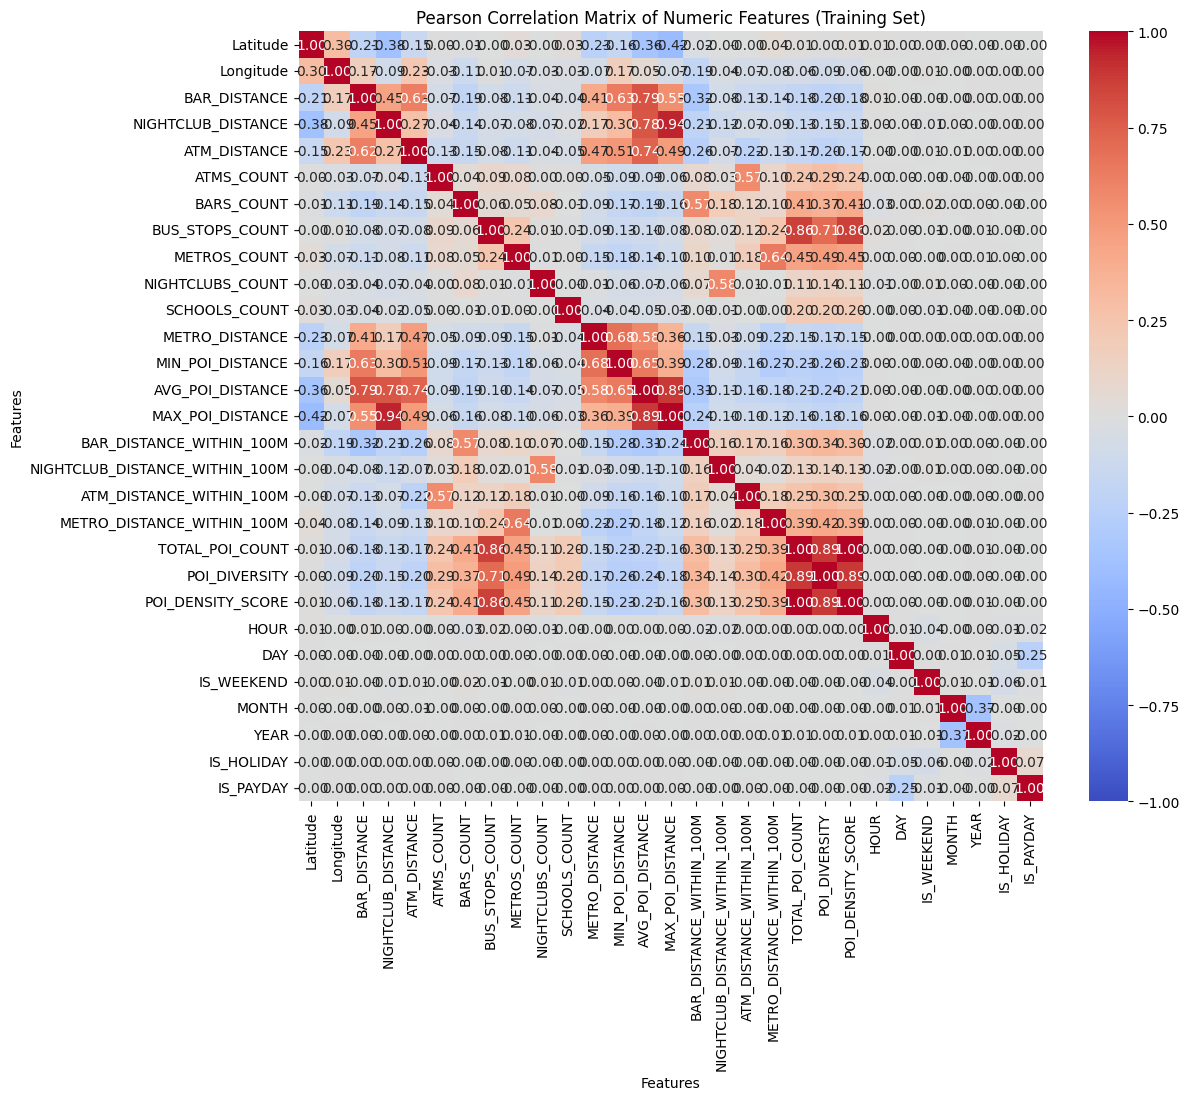

Correlation matrix displayed.


In [ ]:
print("\n=== Final Data Scan (Unprocessed Training Data) ===") 
if 'X_train' in locals() and not X_train.empty:
    print(f"X_train shape: {X_train.shape}") 
    print(f"Sample of X_train (first 5 rows):\n{X_train.head()}") 

    if 'y_train' in locals() and not y_train.empty:
        print(f"y_train shape: {y_train.shape} (Note: y_train is currently a dummy target)") 
    else:
       print("y_train is not defined or is empty.")

    print("\n=== Correlation Matrix (Original Numeric Features in Training Set) ===") 
    # Assuming X_train contains all features, already numerically encoded from FeatureEngineering.ipynb
    # So, all columns should be numeric.
    original_numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()

    if original_numeric_cols:
        print(f"Calculating correlation matrix for {len(original_numeric_cols)} numeric features in X_train.") 
        # Downsample for large number of features to make heatmap readable/performant
        if len(original_numeric_cols) > 50:
           print(f"Too many numeric features ({len(original_numeric_cols)}) for full heatmap. Plotting for a sample or skipping. For now, skipping detailed plot.")
            # Sample a subset of columns for correlation matrix display
            sample_cols = original_numeric_cols[:50] # First 50 columns, adjust as needed
            correlation_matrix_sample = X_train[sample_cols].corr(method='pearson')
            plt.figure(figsize=(12, 10))
            sns.heatmap(correlation_matrix_sample, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
            plt.title('Pearson Correlation Matrix Sample of Numeric Features (Training Set)')
            plt.xlabel('Features')
            plt.ylabel('Features')
            plt.show()
            print("Sample correlation matrix displayed.") 
        else:
            # Full correlation matrix display
            correlation_matrix = X_train[original_numeric_cols].corr(method='pearson')
            plt.figure(figsize=(12, 10))
            sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
            plt.title('Pearson Correlation Matrix of Numeric Features (Training Set)')
            plt.xlabel('Features')
            plt.ylabel('Features')
            plt.show()
            print("Correlation matrix displayed.") 
    else:
        print("No numeric columns found in X_train to calculate correlation matrix.")
else:
    print("X_train is not defined or is empty. Cannot perform final data scan.")


In [ ]:
# This cell seems to have a 'column_mapping' argument not defined in this notebook.
# I will adapt it to use available information or make it more self-contained.

def perform_final_validation_and_reporting(save_dir_path: str, 
                                          x_train_df: pd.DataFrame = None, 
                                          x_test_df: pd.DataFrame = None) -> None: # Made DFs optional
    """
    Perform final validation and generate comprehensive reports.
    
    Args:
        save_dir_path: Directory containing saved artifacts
        x_train_df: Training data (optional, used for some checks if provided)
        x_test_df: Test data (optional, used for some checks if provided)
    """
    print("\n=== Final Validation and Reporting ===") 
    print(f"Checking artifacts in: {save_dir_path}") 
    
    # Validate saved artifacts
    required_files = [
        'X_train.npy', 'X_test.npy', 'y_train.npy', 'y_test.npy',
        'X_feature_names.joblib', 
        'preprocessing_pipeline_general.joblib', # Full pipeline CT+PCA
        'preprocessor_full.joblib', # Just CT for general
        'preprocessor_trees.joblib', # Just CT for trees
        'stkde_optimal_params.json',
        'scaler_info.json' # Added scaler_info.json
    ]
    
    print("Validating saved artifacts existence and size...") 
    missing_files_list = []
    present_files_info = {}
    for file_item in required_files:
        file_path_full = os.path.join(save_dir_path, file_item)
        if not os.path.exists(file_path_full):
            missing_files_list.append(file_item)
           print(f"  ❌ Missing artifact: {file_item}")
        else:
            file_size = os.path.getsize(file_path_full)
            print(f"  ✓ Present: {file_item} ({file_size:,} bytes)") 
            present_files_info[file_item] = file_size
    
    if missing_files_list:
        print(f"❌ Critical error: Missing required preprocessing files: {missing_files_list}")
    else:
        print("✓ All critical required files appear to be present.") 
    
    print("Performing high-level data quality validation summary...") 
    
    train_time_range_info = None
    test_time_range_info = None
    temporal_split_valid_info = None # Initialize
    
    if x_train_df is not None and not x_train_df.empty and all(col in x_train_df.columns for col in ['YEAR', 'MONTH']):
        train_years = x_train_df['YEAR'].astype(int)
        train_time_range_info = (train_years.min(), train_years.max())
        print(f"Train time range: {train_time_range_info}")

        if x_test_df is not None and not x_test_df.empty and all(col in x_test_df.columns for col in ['YEAR', 'MONTH']):
            test_years = x_test_df['YEAR'].astype(int)
            test_time_range_info = (test_years.min(), test_years.max())
            if train_time_range_info and test_time_range_info: # Both must be valid tuples
                temporal_split_valid_info = train_time_range_info[1] < test_time_range_info[0]
                print(f"Temporal split check: Train range {train_time_range_info}, Test range {test_time_range_info}. Valid: {temporal_split_valid_info}")
            else:
                print("Could not perform full temporal split validation due to missing year/month data in train/test after year processing.")
        else:
           print("X_test_df not provided or YEAR/MONTH missing in it, skipping test time range and full temporal validation.")
    else:
       print("X_train_df not provided or YEAR/MONTH missing in it, skipping some temporal validations.")

    print("Analyzing feature characteristics (from saved names)...") 
    feature_names_path = os.path.join(save_dir_path, 'X_feature_names.joblib')
    num_features = 0
    saved_feature_names = [] # Initialize to empty list
    if os.path.exists(feature_names_path):
        saved_feature_names = joblib.load(feature_names_path)
        num_features = len(saved_feature_names)
        print(f"Number of features in saved X_feature_names.joblib: {num_features}") 
        print(f"Sample features: {saved_feature_names[:10]}") 
    else:
       print("X_feature_names.joblib not found. Cannot report on feature details.")
    
    validation_report_data = {
        'validation_date': time.strftime('%Y-%m-%d %H:%M:%S'),
        'data_validation': {
            'train_shape': list(x_train_df.shape) if x_train_df is not None and not x_train_df.empty else None,
            'test_shape': list(x_test_df.shape) if x_test_df is not None and not x_test_df.empty else None,
            'temporal_split_valid': temporal_split_valid_info,
            'train_time_range': train_time_range_info,
            'test_time_range': test_time_range_info
        },
        'feature_analysis': {
            'num_features': num_features,
            'feature_sample': saved_feature_names[:10] if saved_feature_names else None
        },
        'quality_checks': {
            'all_required_files_present': len(missing_files_list) == 0,
            'temporal_split_valid': temporal_split_valid_info 
        }
    }
    
    report_path = os.path.join(save_dir_path, 'validation_report.json')
    try:
        with open(report_path, 'w') as f:
            json.dump(validation_report_data, f, indent=2)
        print(f"Preprocessing validation report saved to: {report_path}") 
    except Exception as e:
        print(f"Error saving preprocessing validation report: {e}")
    
    print("✓ Final validation and reporting checks completed.") 
    
    # Print summary
    print("\n" + "="*60) 
    print("PREPROCESSING PHASE COMPLETED (AlternativePreprocessing.ipynb)") 
    print("="*60) 
    if x_train_df is not None and not x_train_df.empty: print(f"Training samples processed (at time of split): {len(x_train_df):,}")
    if x_test_df is not None and not x_test_df.empty: print(f"Test samples processed (at time of split): {len(x_test_df):,}")
    print(f"Total features for modeling (from saved list): {num_features}") 
    print(f"Artifacts saved to: {save_dir_path}") 
    print("\nReady for modeling phase (Modeling.ipynb)!") 
    print("="*60) 

# Perform final validation and reporting
# Pass X_train and X_test if they are loaded and available in this scope, otherwise they default to None
current_X_train = locals().get('X_train')
current_X_test = locals().get('X_test')

try:
    perform_final_validation_and_reporting(save_dir, current_X_train, current_X_test)
except Exception as e:
    print(f"❌ Final validation script encountered an error: {e}", exc_info=True)
    # raise # Optional: re-raise the exception if script failure should stop execution

2025-05-27 21:46:37,613 - ERROR - Error saving preprocessing validation report: Object of type bool is not JSON serializable



=== Final Validation and Reporting ===
Checking artifacts in: c:\Users\ferdi\Desktop\Uni\Roba\DMML\Classification (Preprocessing)
Validating saved artifacts existence and size...
  ✓ Present: X_train.npy (161,845,642 bytes)
  ✓ Present: X_test.npy (41,995,162 bytes)
  ✓ Present: y_train.npy (1,514,441 bytes)
  ✓ Present: y_test.npy (393,059 bytes)
  ✓ Present: X_feature_names.joblib (594 bytes)
  ✓ Present: preprocessing_pipeline_general.joblib (1,877 bytes)
  ✓ Present: preprocessor_full.joblib (1,563 bytes)
  ✓ Present: preprocessor_trees.joblib (1,043 bytes)
  ✓ Present: stkde_optimal_params.json (28 bytes)
  ✓ Present: scaler_info.json (44 bytes)
✓ All critical required files appear to be present.
Performing high-level data quality validation summary...
Train time range: (np.int64(2023), np.int64(2024))
Temporal split check: Train range (np.int64(2023), np.int64(2024)), Test range (np.int64(2024), np.int64(2024)). Valid: False
Analyzing feature characteristics (from saved names)..